In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px 
import matplotlib.pyplot as plt
import xlrd
from scipy.linalg import svd
from matplotlib.pyplot import figure, plot, title, xlabel, ylabel, show, legend
from scipy.linalg import svd
from sklearn.impute import SimpleImputer
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics.pairwise import cosine_similarity
import sys
import os
#!pip install mmh3
import mmh3
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier 
from random import randrange
from collections import Counter

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

## Data investigation

In [3]:
#data = pd.read_csv('/content/drive/MyDrive/Computational tools for DS/data.csv')
data = pd.read_csv('data/data.csv')

In [4]:
data.info()
songNames = data.loc[:,'name'];

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

In [5]:
data.T

,0,1,2,3,4,5,6,7,8,9,...,170643,170644,170645,170646,170647,170648,170649,170650,170651,170652
valence,0.0594,0.963,0.0394,0.165,0.253,0.196,0.406,0.0731,0.721,0.771,...,0.907,0.466,0.169,0.522,0.0838,0.608,0.734,0.637,0.195,0.642
year,1921,1921,1921,1921,1921,1921,1921,1921,1921,1921,...,2020,2020,2020,2020,2020,2020,2020,2020,2020,2020
acousticness,0.982,0.732,0.961,0.967,0.957,0.579,0.996,0.993,0.996,0.982,...,0.00952,0.31,0.994,0.204,0.974,0.0846,0.206,0.101,0.00998,0.132
artists,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",['Dennis Day'],['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,['Frank Parker'],['Phil Regan'],['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,['John McCormack'],['Sergei Rachmaninoff'],['Ignacio Corsini'],['Fortugé'],...,"['DJ Scheme', 'Cordae', 'Ski Mask The Slump Go...",['Fleet Foxes'],['Ólafur Arnalds'],['Gunna'],['Najma Wallin'],"['Anuel AA', 'Daddy Yankee', 'KAROL G', 'Ozuna...",['Ashnikko'],['MAMAMOO'],['Eminem'],"['KEVVO', 'J Balvin']"
danceability,0.279,0.819,0.328,0.275,0.418,0.697,0.518,0.389,0.485,0.684,...,0.917,0.562,0.281,0.598,0.175,0.786,0.717,0.634,0.671,0.856
duration_ms,831667,180533,500062,210000,166693,395076,159507,218773,161520,196560,...,228333,253613,190500,230600,133500,301714,150654,211280,337147,189507
energy,0.211,0.341,0.166,0.309,0.193,0.346,0.203,0.088,0.13,0.257,...,0.569,0.686,0.0333,0.472,0.00759,0.808,0.753,0.858,0.623,0.721
explicit,0,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,1,1
id,4BJqT0PrAfrxzMOxytFOIz,7xPhfUan2yNtyFG0cUWkt8,1o6I8BglA6ylDMrIELygv1,3ftBPsC5vPBKxYSee08FDH,4d6HGyGT8e121BsdKmw9v6,4pyw9DVHGStUre4J6hPngr,5uNZnElqOS3W4fRmRYPk4T,02GDntOXexBFUvSgaXLPkd,05xDjWH9ub67nJJk82yfGf,08zfJvRLp7pjAb94MA9JmF,...,3C9D1X8NkG2Ak1RaGpRnnQ,308prODCCD0O660tIktbUi,13MOQ6oQqkrZEDkZOHukCw,2f8y4CuG57UJEmkG3ujd0D,6RuFOroO9VO0aMGEzirLHk,0KkIkfsLEJbrcIhYsCL7L5,0OStKKAuXlxA0fMH54Qs6E,4BZXVFYCb76Q0Klojq4piV,5SiZJoLXp3WOl3J4C8IK0d,7HmnJHfs0BkFzX4x8j0hkl
instrumentalness,0.878,0.0,0.913,0.000028,0.000002,0.168,0.0,0.527,0.151,0.0,...,0.0,0.0225,0.959,0.000015,0.925,0.000289,0.0,0.000009,0.000008,0.00471


<AxesSubplot:xlabel='decade', ylabel='Count'>

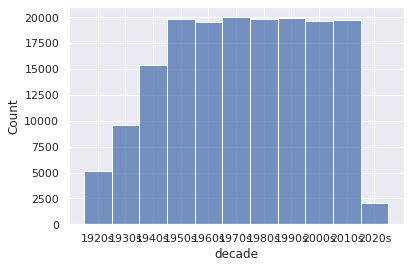

In [6]:
# Visualizing the amount of songs by the decades in the dataset 
def get_decade(year):
    start = int(year/10) * 10
    decade = '{}s'.format(start)
    return decade

data['decade'] = data['year'].apply(get_decade)

sns.set(rc={'figure.figsize':(11 ,6)})
sns.histplot(data['decade'])


<AxesSubplot:xlabel='decade', ylabel='tempo'>

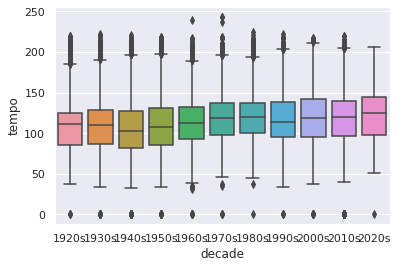

In [7]:
sns.boxplot(x = data['decade'], y= data['tempo'])
#sns.boxplot(x = data['decade'], y= data['energy'])
#sns.boxplot(x = data['decade'], y= data['acousticness'])

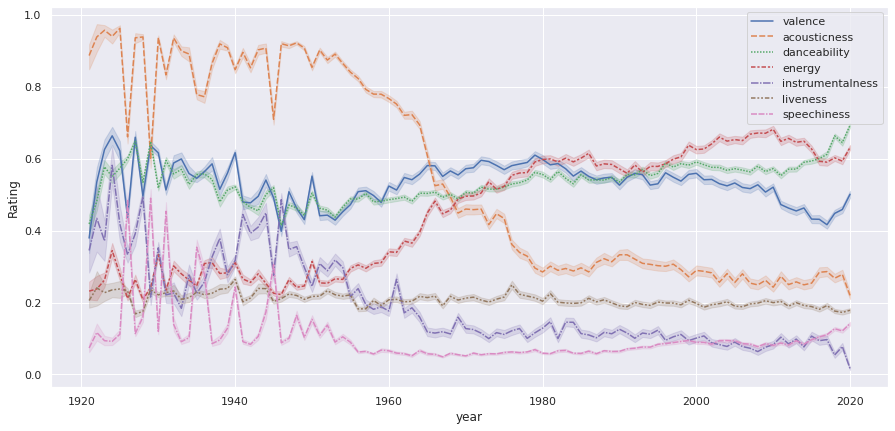

In [8]:
# Visualizing different songs features to see how the evolve
features = ['year','valence','acousticness','danceability','energy','instrumentalness','liveness','speechiness'] # relevant features that is scaled between 0-1
data_melted = data[features].melt("year",var_name="Features",value_name="Rating")
sns.set(rc={'figure.figsize':(15 ,7)})
sns.lineplot(data=data_melted, x="year", y="Rating", hue="Features", style = 'Features')
plt.legend(loc='upper right')

<AxesSubplot:xlabel='Rating', ylabel='Features'>

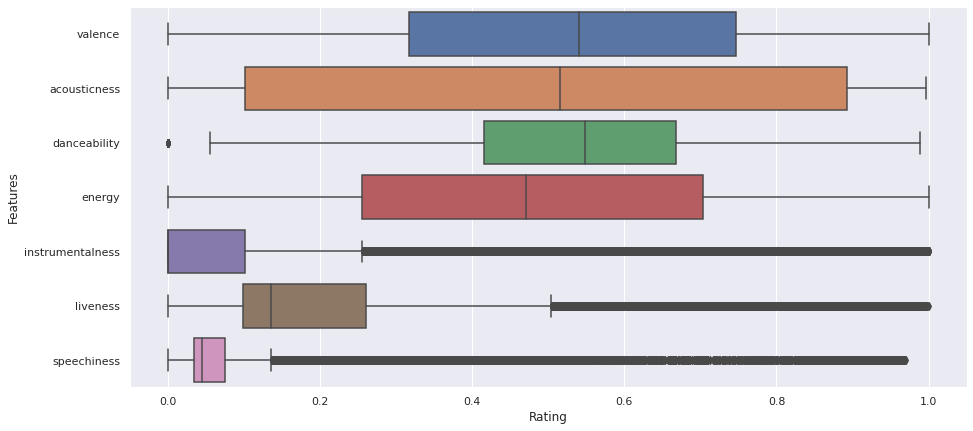

In [9]:
# Boxplot of the rating for the features 
sns.boxplot(data=data_melted, x="Rating", y ='Features')

In [10]:
corr = data.corr()
corr.style.background_gradient(cmap='RdYlGn')

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
valence,1.000000,-0.028245,-0.184101,0.558946,-0.191813,0.353876,-0.018613,-0.198501,0.028473,0.003832,0.313512,0.015641,0.014200,0.046381,0.171689
year,-0.028245,1.000000,-0.614250,0.188515,0.079713,0.530272,0.220881,-0.272371,0.007540,-0.057318,0.487697,-0.032385,0.862442,-0.167816,0.141048
acousticness,-0.184101,-0.614250,1.000000,-0.266852,-0.076373,-0.749393,-0.246007,0.329819,-0.020550,-0.024482,-0.561696,0.047168,-0.573162,-0.043980,-0.207120
danceability,0.558946,0.188515,-0.266852,1.000000,-0.139937,0.221967,0.241757,-0.278063,0.024439,-0.100193,0.285057,-0.045956,0.199606,0.235491,0.001801
duration_ms,-0.191813,0.079713,-0.076373,-0.139937,1.000000,0.042119,-0.048880,0.084770,-0.004266,0.047168,-0.003037,-0.046085,0.059597,-0.084604,-0.025472
energy,0.353876,0.530272,-0.749393,0.221967,0.042119,1.000000,0.132723,-0.281101,0.027705,0.126192,0.782362,-0.039260,0.485005,-0.070555,0.250865
explicit,-0.018613,0.220881,-0.246007,0.241757,-0.048880,0.132723,1.000000,-0.140987,0.005432,0.039640,0.140300,-0.078872,0.191543,0.414070,0.011969
instrumentalness,-0.198501,-0.272371,0.329819,-0.278063,0.084770,-0.281101,-0.140987,1.000000,-0.014591,-0.047193,-0.408611,-0.036543,-0.296750,-0.121700,-0.105361
key,0.028473,0.007540,-0.020550,0.024439,-0.004266,0.027705,0.005432,-0.014591,1.000000,0.000205,0.017385,-0.116260,0.007826,0.023784,0.002629
liveness,0.003832,-0.057318,-0.024482,-0.100193,0.047168,0.126192,0.039640,-0.047193,0.000205,1.000000,0.056422,0.002641,-0.076464,0.134667,0.007714


In [11]:
# Finding unique combinations of artists on a song
artists = []
for i in data['artists'].values:
    if i in artists:
        continue
    else:
        artists.append(i)

# Printing the unique combinations 
len(artists)

34088

In [12]:
# Finding the average duration of the songs
print("The average duration of the songs is", round(data['duration_ms'].mean()/1000), "seconds")
print("The average tempo of the songs is", round(data['tempo'].mean()))


The average duration of the songs is 231 seconds
The average tempo of the songs is 117


## Data Preparation/Pre-processing:

In [13]:
# Remove qualitative rows for easier computation, standardize and normalize data
data2 = data.drop(columns = ['artists','id','name', 'release_date','decade'])
data2 = SimpleImputer(strategy='mean').fit_transform(data2)
data2 = StandardScaler().fit_transform(data2)
N, M = data2.shape

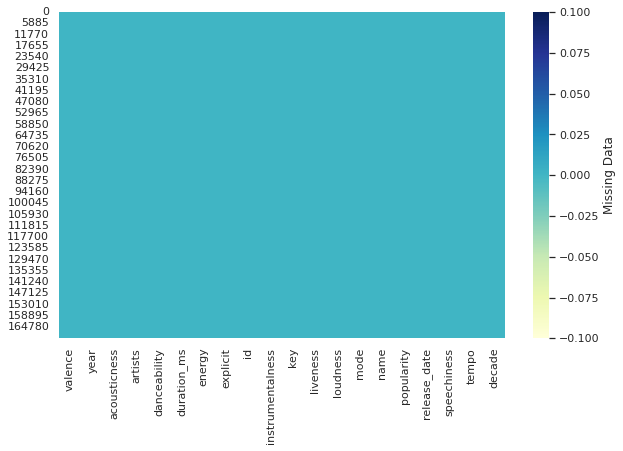

In [14]:
# Visualize any missing data 
plt.figure(figsize=(10,6))
sns.heatmap(data.isna(), cmap="YlGnBu", cbar_kws={'label': 'Missing Data'})
plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python.png", dpi=100)


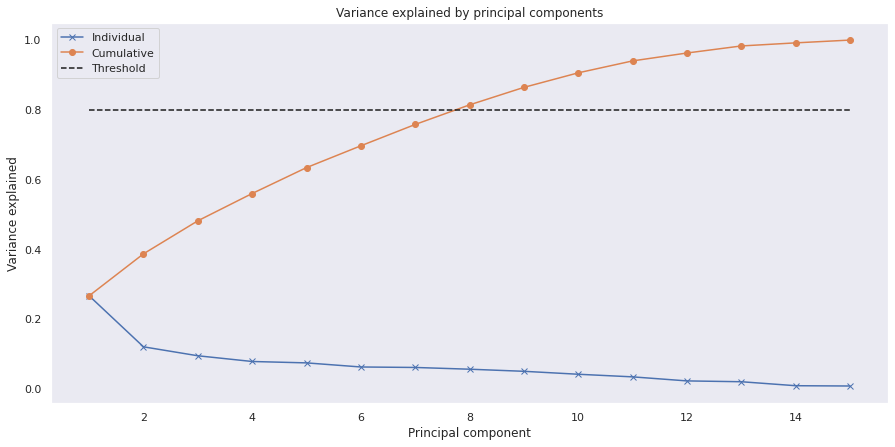

In [15]:
# PCA Analysis 
Y = data2 - np.ones((N,1))*data2.mean(axis=0)
U,S,V = svd(Y,full_matrices=False)
rho = (S*S) / (S*S).sum() 
threshold = 0.8

plt.figure()
plt.plot(range(1,len(rho)+1),rho,'x-')
plt.plot(range(1,len(rho)+1),np.cumsum(rho),'o-')
plt.plot([1,len(rho)],[threshold, threshold],'k--')
plt.title('Variance explained by principal components')
plt.xlabel('Principal component')
plt.ylabel('Variance explained')
plt.legend(['Individual','Cumulative','Threshold'])
plt.grid()
plt.show()

Y = data2 - np.ones((N,1))*data2.mean(0)
U,S,Vh = svd(Y,full_matrices=False)
V = Vh.T    
Z = Y @ V

8 0.8142233124132674


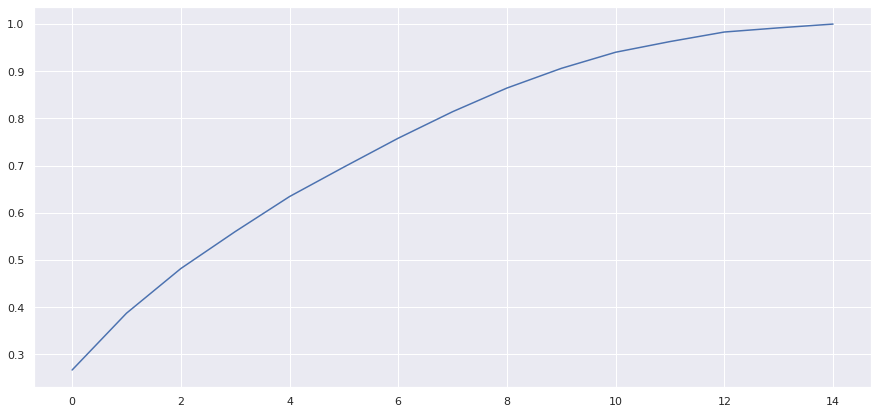

In [16]:
# PCA Analysis using library in python
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(data2)
pca.explained_variance_ratio_

# Plt cumulative graph of total variance 
expl = pca.explained_variance_ratio_
cdf = [sum(expl[:i+1]) for i in range(len(expl))]
plt.plot(range(len(expl)), cdf);

# Finding the number of principal components needed
i = 0
threshold = 0.80
while cdf[i] < threshold:
    i += 1
print(i+1, cdf[i])

In [22]:
# Decomposition of the data
from sklearn import decomposition
pca_new=decomposition.PCA(n_components=8)
pca_new.fit(data2)
X_reduced=pca_new.transform(data2)
X_reduced.shape


(170653, 8)

## K-Means Clustering

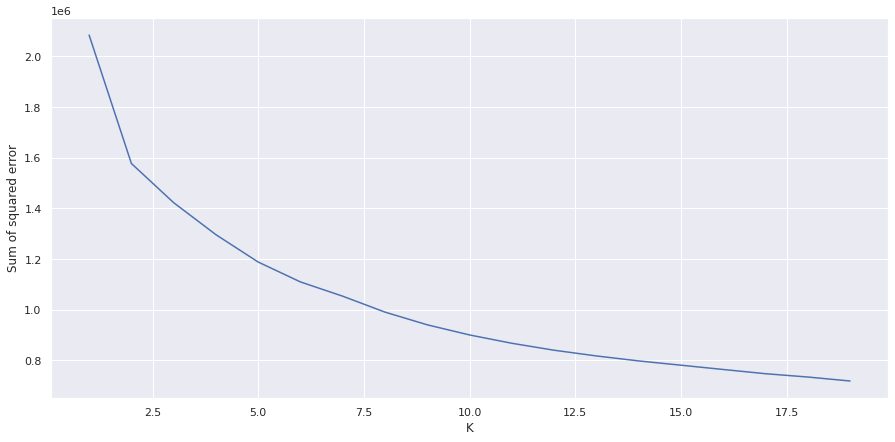

In [23]:
# Determine number of clusters for K-Means by plotting clusters vs. SSE
sse = []
k_rng = range(1,20)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(X_reduced)
    sse.append(km.inertia_)

plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

In [24]:
# Performs K-Means Clustering on dataset, k = 10
clt = KMeans(n_clusters=10)
model = clt.fit(X_reduced)
centroids = clt.cluster_centers_
clusters = pd.DataFrame(model.fit_predict(X_reduced))
label = clt.fit_predict(X_reduced)
clusters['cluster'] = model.labels_


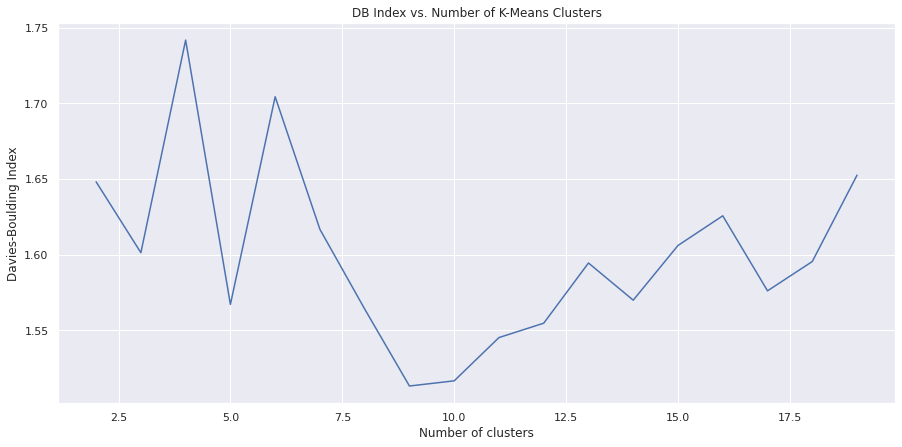

In [25]:
# Plots DB Index Graph to determine number of clusters
results = {}
for i in range(2,20):
    kmeans = KMeans(n_clusters=i, random_state=30)
    labels = kmeans.fit_predict(X_reduced)
    db_index = davies_bouldin_score(X_reduced, labels)
    results.update({i: db_index})
    
plt.plot(list(results.keys()), list(results.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Davies-Boulding Index")
plt.title("DB Index vs. Number of K-Means Clusters")
plt.show()

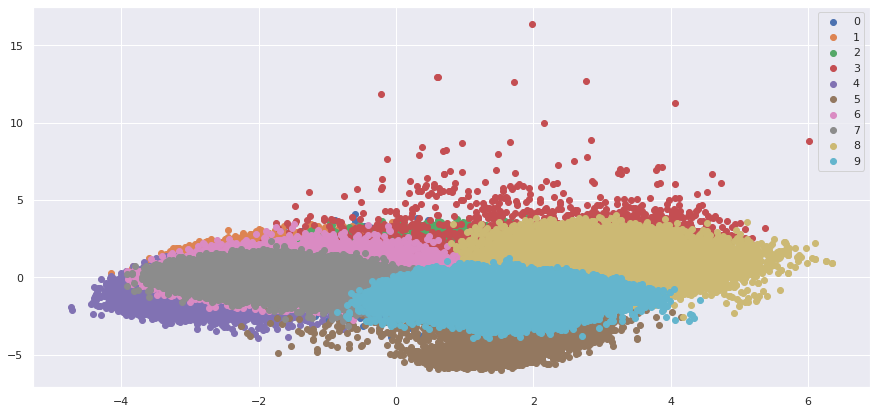

In [26]:
# Plotting the K-Means Cluster results:
u_labels = np.unique(label)

for i in u_labels:
    plt.scatter(X_reduced[label == i , 0] , X_reduced[label == i , 1] , label = i)
plt.legend()
plt.show()

In [27]:
# Classification by finding euclidean distance to the nearest centroid
def closest_centroid(X):
    num_clusters = len(centroids)
    L = len(centroids[0])
    diff=np.zeros(shape = (num_clusters,L),dtype = 'float')
    id = 0;   #id is index of the closest centroid
    diff[0, :] = X - centroids[0,:]
    min_distance = sum(np.multiply(diff[0,:],diff[0,:]))
    for j in range(1,num_clusters):
        diff[j, :] = X - centroids[j,:]
        distance = sum(np.multiply(diff[j,:],diff[j,:]))
        if (distance<min_distance):
            min_distance = distance
            id = j
    return id

In [98]:
# Predicts song recommendations using closest centroid method given a song input
def cluster_pred(song_id,numsongs):
    song_id_arr = X_reduced.iloc[3,:].to_list()
    clust_num = closest_centroid(song_id_arr)
    clust = clusters[clusters.cluster == clust_num ]
    song_list = list()
    for song in range(numsongs):
        id_list = clust.sample().index;
        song_list.append(data.iloc[id_list,14].tolist())
        song_list_flattened  = [val for sublist in song_list for val in sublist]
    return song_list_flattened

In [97]:
# Test - recommends 10 songs based on K-Means clustering method 
print(cluster_pred(3,10))

Kapitel 219 - Der Page und die Herzogin
Часть 91.3 - По ком звонит колокол
Часть 85.2 - По ком звонит колокол
Часть 104.2 - По ком звонит колокол
Часть 86.4 & Часть 87.1 - Зеленые холмы Африки
Toss of the Coin
Kapitel 389 - Der Page und die Herzogin
Das ist bei uns nicht möglich, Kapitel 101
Capítulo 24.4 - la Sombra Fuera del Tiempo
Часть 2.12 - Обратный путь
['Kapitel 219 - Der Page und die Herzogin', 'Часть 91.3 - По ком звонит колокол', 'Часть 85.2 - По ком звонит колокол', 'Часть 104.2 - По ком звонит колокол', 'Часть 86.4 & Часть 87.1 - Зеленые холмы Африки', 'Toss of the Coin', 'Kapitel 389 - Der Page und die Herzogin', 'Das ist bei uns nicht möglich, Kapitel 101', 'Capítulo 24.4 - la Sombra Fuera del Tiempo', 'Часть 2.12 - Обратный путь']


## Decision Tree From Scratch 

In [31]:
# A function for checking for the amount of unique types, purity check. The data is pure if it only have one one unique value
def purity_check(data):
    types = data[:,-1]
    unique_types = np.unique(types)
    if len(unique_types) == 1:
        return True
    else:
        return False

In [32]:
# Making a classifier that will also make the leaf nodes in the decision tree
def classifier(data):
    types = data[:,-1]
    unique_types,unique_types_count = np.unique(types,return_counts=True)
    index = unique_types_count.argmax()
    classification = unique_types[index]
    return classification

In [33]:
# Getting the potentiel splits by iterating over the different columns(attributes) in the data, then finding the unique values and taking the mid point of these values as the potential split
def get_potential_splits(data):
    potential_splits={}
    _,column_no=data.shape 
    for column_index in range(column_no-1):
        values=data[:,column_index] #Finding all values in the column
        unique_values=np.unique(values) #Unique values
        mid_points=(unique_values[1:]+unique_values[:-1])/2 #calculating the midpoints
        potential_splits[column_index]=mid_points #potential splits
    return potential_splits

In [34]:
# A function to split the data. It takes the best split column and value and split them into a left and right interior node
def data_split(data,split_col,split_val):
    split_col_val = data[:,split_col] #finding the values from the columns after the nodes have been split 
    left = data[split_col_val <= split_val] #left split
    right = data[split_col_val > split_val] #right split 
    return left,right

In [35]:
# Calculating the entropy which is used to determine the purity of the splits.
def cal_entropy(data):
    types = data[:,-1]
    _,count = np.unique(types,return_counts=True)
    prob = count/count.sum() #calculating the probability from  by dividing the count of the unique types by the sum of all counts 
    entropy = -sum(prob*np.log2(prob)) #Using the formula for calculating entropy
    return entropy

In [36]:
# Calculating the overall entropy by adding the entropy from the left and right node
def overall_entropy(left,right):
    data_points = len(left) + len(right)
    p_left = len(left) / data_points
    p_right = len(right) / data_points
    overall_entropy = (p_left * cal_entropy(left)+p_right * cal_entropy(right))
    return overall_entropy

In [37]:
# Finding the best splits
def best_split(data,pot_splits):
    fixed_entropy = 999 # Seeting a high fixed entropy that will be used
    for col_index in pot_splits: #Iterating over column index from the potential splits that are found by the get potential split function 
        for val in pot_splits[col_index]: #Iterating over the values from the column index from the potential splits that are found by the get potential split function 
            left,right = data_split(data,split_col=col_index,split_val=val) # splitting the data into two nodes
            current_entropy = overall_entropy(left,right) #setting the overall entropy of the two nodes to the current entropy
            if current_entropy <= fixed_entropy:
                fixed_entropy= current_entropy #If the current entropy is lower than the fixed entropy the current entropy becomes the new fixed entropy
                best_s_col = col_index # saving the column index as the best split column
                best_s_val = val # saving the corresponding value as the best split value
    return best_s_col, best_s_val

In [38]:
# Making the decision tree
def decision_tree(df,counter, max_depth):
    if counter == 0:
        global col_header #setting as a global value so it keeps it name throughout the recursion
        col_header = df.columns #retriving the name of the columns
        data = df.values #saving the values from the dataframe with pandas
    else:
        data = df
    #base case
    if purity_check(data) or (counter == max_depth): #Base for the function to stop recursion
        leaf = classifier(data)
        return leaf #returns the a leaf node also known as the leaf node
    #Recursion
    else:
        counter += 1
        pot_splits = get_potential_splits(data) #Finding the potential splits for the data
        split_col,split_val = best_split(data,pot_splits) #Getting the best split based on the potential splits
        left,right = data_split(data,split_col,split_val) #Splitting the data into interior nodes
        
        # Checking for empty data and if empty returns a leaf node
        if len(left) == 0 or len(right) == 0:
            leaf = classifier(data)
            return leaf
        #nodes
        name = col_header[split_col] # Finding the name based on the colums name and columns split
        question = "{} <= {}".format(name,split_val) #Forming the question for each interior node
        node = {question:[]} #Making the interior node
        
        #Answer the question
        yes = decision_tree(left,counter,max_depth) #Finding the yes answers
        no = decision_tree(right,counter,max_depth) #Finding the no answers
        
        node[question].append(yes) #Appending the yes answers
        node[question].append(no) #Appending the no answers

        return node

In [73]:
# Making a classify example that will be used the prediction
def classify_ex(example,tree):
    
    #if the tree is just a root node
    if not isinstance(tree,dict):
        return tree
    
    question = list(tree.keys())[0] #Finding just the questions
    name,operator,val = question.split() #Splitting the question into the name, operator and value
    
    #Finding the answer that will be used to make the predictions  
    if example[name] <= float(val):
        answer = tree[question][0]
    else:
        answer = tree[question][1]
        
    if not isinstance(answer,dict):
        return answer
    
    else:
        residual_tree = answer
        return classify_ex(example,residual_tree)

In [40]:
def recommend_dict(songs, tree, data):
    tmp = []
    artist = []
    song_recom = []
    df = pd.DataFrame()
    for i in songs:
        if data['name'].str.contains(i).any():
            index = data['name'][data['name'] == i].index[0]
            df = df.append(data[['danceability','duration_ms','energy','popularity','cluster','valence','acousticness','explicit','instrumentalness','key','liveness','mode','speechiness','tempo']][index:index+1])
    for i in range(0,len(df)):
        g = []
        hell = df[i:i+1]
        m = classify_ex(hell,tree)
        sim_songs = data['name'][data['cluster'] == m].sample(n= 10)
    for i in sim_songs:
        song_recom.append(i)
    for i in song_recom:
        if data['name'].str.contains(i).any():
            index = data['name'][data['name'] == i].index[0]
            tmp.append(data['artists'][index:index+1])    
    for i in tmp:
        for x in i:
            artist.append(x)
    res = dict(zip(artist, song_recom))
    return res

In [41]:
def recommend_songs(songs, tree, data):
    song_recom = []
    df = pd.DataFrame()
    for i in songs:
        if data['name'].str.contains(i).any():
            index = data['name'][data['name'] == i].index[0]
            df = df.append(data[['danceability','duration_ms','energy','popularity','cluster','valence','acousticness','explicit','instrumentalness','key','liveness','mode','speechiness','tempo']][index:index+1])
    for i in range(0,len(df)):
        g = []
        hell = df[i:i+1]
        m = classify_ex(hell,tree)
        sim_songs = data['name'][data['cluster'] == m].sample(n= 10)
    for i in sim_songs:
        song_recom.append(i)
    return song_recom

In [42]:
# recommend on PCA data
def recom(index, tree, data, original_data):
    song_list = list();
    sim_of_indiv_song = data.iloc[index];
    m = classify_ex(sim_of_indiv_song,tree)
    tmp = original_data['name'][original_data['cluster'] == m].sample(n= 10)
    
    #sim_of_indiv_song = sim_of_indiv_song.sort_values(ascending=False);
    #sim_of_indiv_song = sim_of_indiv_song[0:num_songs];
    #song_id = sim_of_indiv_song.index;
    for i in tmp:
        song_list.append(i)
    return song_list;

In [76]:
# Adding the cluster number to the data to use for the decision tree
X_reduced_tree = pd.DataFrame(X_reduced)
X_reduced_tree = X_reduced.rename(columns={0: "PCA0", 1: "PCA1", 2: "PCA2", 3: "PCA3", 4: "PCA4", 5: "PCA5", 6: "PCA6", 7: "PCA7", 8: "PCA8"})
X_reduced_tree['cluster'] = clusters[0]
data['cluster'] = clusters[0]

In [44]:
# Getting training data for the decision tree
train = X_reduced.sample(n= 50000)

In [45]:
# Setting the max depth for the decision tree
counter = 0
max_depth = 4

In [46]:
# Running the decision tree
tree = decision_tree(train,counter,max_depth)

In [91]:
tree

{'PCA0 <= -0.020539867249146096': [{'PCA2 <= 1.1661138449661386': [{'PCA4 <= 0.8290177729975929': [{'PCA3 <= 1.1243309081477864': [1.0,
        9.0]},
      {'PCA7 <= 0.5617595365787885': [6.0, 1.0]}]},
    {'PCA1 <= 0.8251347731124794': [{'PCA0 <= -1.7634859814456654': [4.0,
        4.0]},
      {'PCA3 <= 1.3597137680740041': [6.0, 9.0]}]}]},
  {'PCA1 <= -0.2262897119577551': [{'PCA2 <= 0.6887394691719135': [{'PCA0 <= 2.583408333102769': [3.0,
        3.0]},
      {'PCA1 <= -2.6121014460523106': [5.0, 7.0]}]},
    {'PCA0 <= 2.031983318022677': [{'PCA3 <= 0.944400852541201': [8.0, 9.0]},
      {'PCA7 <= 1.262793588327254': [7.0, 0.0]}]}]}]}

In [47]:
# Recommend songs based on the song from the list
#recommend_songs(song,tree,data)

In [48]:
# Recommend songs + artists based on the song from the list
#recommend_dict(song,tree,data)

## Cosine Similarity 

In [95]:
# Creates a matrix that computes cosine similarity between songs
X_reduced = pd.DataFrame(X_reduced)
df_percent = X_reduced.sample(frac=0.1)

def cosine_sim_pred(index,num_songs):
    similarities = cosine_similarity(df_percent)
    cosine_sim = pd.DataFrame(similarities)
    song_list = list()

    sim_of_indiv_song = cosine_sim.iloc[index]
    sim_of_indiv_song = sim_of_indiv_song.sort_values(ascending=False)
    sim_of_indiv_song = sim_of_indiv_song[0:num_songs]
    song_id = sim_of_indiv_song.index

    for song in song_id:
        data.iloc[song,14]
        song_list.append(data.iloc[song,14])

    return song_list;

In [50]:
# Test - recommends 10 songs using Cosine Similarity Method
print(cosine_sim_pred(3,10))

Danny Boy
Ants Marching
No Milk Today
Make It Last Forever (with Jacci McGhee)
Munchkinland
Lady
You And I
I Am A Pilgrim
Rubin And Cherise
You Might Think
['Danny Boy', 'Ants Marching', 'No Milk Today', 'Make It Last Forever (with Jacci McGhee)', 'Munchkinland', 'Lady', 'You And I', 'I Am A Pilgrim', 'Rubin And Cherise', 'You Might Think']


## Locality-Sensitivity Hashing - Find similar songs based on lyrical content 

In [51]:
# Read in dataset and create a dataframe for lyrics only 
#song_lyrics = pd.read_csv('/content/drive/MyDrive/Computational tools for DS/spotify_songs_lyrics.csv')
song_lyrics = pd.read_csv('data/spotify_songs_lyrics.csv')
lyrics_data = song_lyrics.iloc[:,3]
lyrics_percent = lyrics_data.sample(frac=1)

In [52]:
# Finding songs in both datasets
data['both'] = data.name.isin(song_lyrics['track_name']).astype(str)
tmp = data[data['both']=='True']

In [53]:
# Hashes a list of strings
def listhash(l,seed):
	val = 0
	for e in l:
		val = val ^ mmh3.hash(e, seed)
	return val 

q = 5 # length of shingle
k = 100 # number of minhashes
docs = {} #dictionary mapping document id to document contents

In [54]:
# Produces a list of shingles where each shingle is a list of q words
def shingle(aString, q, delimiter=' '):
    """
    Input:
        - aString (str): string to split into shingles
        - q (int)
        - delimiter (str): string of the delimiter to consider to split the input string (default: space)
    Return: list of unique shingles
    """
    all_shingles = []
    if delimiter != '':
        words_list = aString.split(delimiter)
    else:
        words_list = aString
    for i in range (len(words_list)-q+1):
        all_shingles.append(delimiter.join(words_list[i:i+q]))
    return list(set(all_shingles))

In [55]:
# Takes list of shingles and seed for the hash function mapping the shingles and outputs the minhash
def minhash(shingles_list, seed):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - seed (int): seed for listhash function
    Return: minhash of given shingles
    """
    minhash_value = None
    for aShingle in shingles_list:
        hashcode = listhash([aShingle], seed)
        if minhash_value == None or hashcode < minhash_value:
            minhash_value = hashcode
    return minhash_value

In [56]:
# Outputs k different minhases in an array 
def minhash2(shingles_list, k):
    """
    Input:
        - shingles_list (list of str): set of hashes
        - k (int): seed for listhash function
    Return: sequence of k minhashes
    """
    all_minhash = []
    for i in range(k):
        all_minhash.append(minhash(shingles_list, i))
    return all_minhash

In [57]:
# Cleans Text 
def clean_text(aString):
    output = aString.replace('\n','')
    output_list = output.split()
    output_list = [''.join(ch for ch in aWord if ch.isalnum()) for aWord in output_list]
    output_list = [s.lower() for s in output_list]
    output = ' '.join(output_list)
    return " ".join(output.split())

In [58]:
# Takes a dictionary and outputs a new dictionary consisting of song id's as keys and signatures as values 
def signature(dict_docs, q = q, num_hashes = k):
    """
    Input:
        - dict_docs (dict of str:str): dictionary of {title:document}
        - q (int)
        - num_hashes (int)
    Return: dictionary consisting of document id’s as keys and signatures as values
    """
    dict_signatures = {}
    total_texts = len(list(dict_docs.keys()))
    counter = 1
    for key,text in dict_docs.items():
#        print(f'{counter}/{total_texts} - {key} - Processing...')
        doc_shingles = shingle(text, q)
        minhash_values = minhash2(doc_shingles, num_hashes)
        dict_signatures[key] = minhash_values
        counter += 1
    return dict_signatures

In [59]:
# Computes Jaccard similarity between two vectors 
def jaccard(name1, name2, signatures_dict):
    """
    Input:
        - name1 (str): key of the first document S
        - name2 (str): key of the second document T
        - signatures_dict (dict of str:list): dictionary of signatures
    Return: Jaccard similarity between S and T
    """
    signatures_doc1 = np.array(signatures_dict[name1])
    signatures_doc2 = np.array(signatures_dict[name2])
    return len(np.intersect1d(signatures_doc1, signatures_doc2))/len(np.union1d(signatures_doc1, signatures_doc2))

In [60]:
# Implement locality-sensitivity hashing which finds all pairs of documents whose estimated Jaccard similarity is ≥ 0.6
b,r = 20, 5
#b,r = 16, 4
assert k == b*r

def lsh(signatures_dict, jaccard_threshold=0.6, seed=42):
    lsh_dict = {}
    for key, values in signatures_dict.items():
        blocks = np.split(np.array(values), b)
        blocks_hash_values = []
        for aBlock in blocks:
            blocks_hash_values.append(mmh3.hash(aBlock, seed))
        lsh_dict[key] = blocks_hash_values
    list_keys = list(lsh_dict.keys())
    similar_items = {}

    for i in range (len(list_keys)-1):
        for j in range (i+1, len(list_keys)):
            common_values = np.intersect1d(lsh_dict[list_keys[i]], lsh_dict[list_keys[j]])
            if len(common_values) > 0:
                # we found a candidate
                similarity_score = jaccard(list_keys[i], list_keys[j], signatures_dict)
                if similarity_score >= jaccard_threshold:
                    similar_items[(list_keys[i], list_keys[j])] = similarity_score

    return similar_items

In [61]:
lyrics = lyrics_percent.astype(str)
i = 0
for song in lyrics:
    docs[song] = str(clean_text(song))
lyrics = lyrics.to_dict() #dictionary mapping document id to document contents

In [62]:
dict_signatures_lyrics = signature(lyrics)

In [63]:
keysNone = [k for k, v in dict_signatures_lyrics.items() if (None in v or 'None' in v or 'none' in v)]
keysNotNone = [x for x in dict_signatures_lyrics.keys() if x not in keysNone]
NoneRem = {key: dict_signatures_lyrics[key] for key in keysNotNone}

In [64]:
found_similar_items_with_lsh = lsh(NoneRem)
found_similar_items_keys = found_similar_items_with_lsh.keys()
#print(found_similar_items_keys)
#print('Found similar items with LSH:\n', found_similar_items_with_lsh)

dict_keys([(18092, 10267), (18092, 5623), (18092, 9423), (18092, 11126), (18092, 1320), (18092, 11853), (18092, 5384), (18092, 3736), (18092, 2860), (18092, 9243), (18092, 13718), (18092, 12081), (18092, 7847), (18092, 13063), (18092, 4415), (18092, 14699), (18092, 5487), (18092, 10143), (18092, 5415), (18092, 3155), (18092, 14294), (18092, 10268), (18092, 3795), (18092, 9718), (18092, 2345), (18092, 14597), (18092, 13288), (18092, 5935), (18092, 5404), (18092, 17724), (18092, 15226), (18092, 2324), (18092, 5000), (18092, 12694), (18092, 17508), (18092, 12655), (18092, 10049), (18092, 1521), (18092, 2718), (18092, 5114), (18092, 8126), (18092, 16171), (18092, 12371), (18092, 6692), (18092, 16154), (18092, 12746), (18092, 11204), (7989, 6909), (6742, 2847), (15935, 17045), (15935, 4376), (15935, 14293), (10660, 7255), (15418, 2965), (10421, 18152), (6848, 12074), (6848, 10760), (6848, 763), (6848, 2138), (16059, 1224), (2974, 9890), (11836, 15771), (2724, 5614), (7776, 404), (7776, 2960

In [65]:
def LSH_find_sim_song(song_id,dict):
    for key, value in dict.items():
        if key[0] == song_id:
            return key[1]
        elif key[1] == song_id:
            return key[0]
        else:
            return 'Not Found'

In [66]:
def LSH_pred(song_id,dict):
    song_pair = LSH_find_sim_song(song_id,dict)
    LSH_list = []
    if song_pair == 'Not Found':
        return LSH_list 
    LSH_list.append(data.iloc[song_pair,14])
    return LSH_list

In [89]:
# Testing - find similar song given song input using LSH 
#print(LSH_find_sim_song(14959,found_similar_items_with_lsh))
#print(LSH_pred(14959,found_similar_items_with_lsh))
#print(LSH_pred(59,found_similar_items_with_lsh))

## Ensemble Methods - Combining multiple models

### Example 1

In [116]:
data['name'][249:250]

249    Tears
Name: name, dtype: object

In [115]:
# Ensemble to combine predictions from all models and count and list the most common songs 
predictions = list()
rand_song_id = 249 # Song is in both datasets
num_songs = 5
decision_pred = recom(rand_song_id,tree,X_reduced_tree,data) # decision tree prediction
cosine_pred = cosine_sim_pred(rand_song_id,num_songs)
clus_pred = cluster_pred(rand_song_id,num_songs)
LSH_song_pred = LSH_pred(rand_song_id,found_similar_items_with_lsh)
predictions = cosine_pred + clus_pred+ decision_pred + LSH_song_pred
def hard_voting(predictions):
    c = Counter(predictions)
    return [k for k, v in c.items() if v == c.most_common(1)[0][1]]
print(hard_voting(predictions))
print(len(hard_voting(predictions)))

['Tears', 'Lover Man', 'Relaxing With Lee - Take 6 / Take 3 / Master Take', 'Ma Chanson', 'Wie man Freunde gewinnt - Die Kunst, beliebt und einflussreich zu werden, Kapitel 52', 'Часть 37.3 & Часть 38.1 - Зеленые холмы Африки', 'Sorge dich nicht - lebe! - Die Kunst, zu einem von Ängsten und Aufregungen befreiten Leben zu finden, Kapitel 7', 'Часть 55.2 - На Западном фронте без перемен', 'If We Must Die (Introduction)', 'Часть 238.4 & Часть 239.1 - Триумфальная арка', 'Nit Nai Rut Ki Bahar Aai', 'Smack Dab In The Middle', 'Para mi Gaucha - Instrumental (Remasterizado)', "There's No Business Like Show Business", 'Going to Memphis', "I Got Cross de River O' Jordan - Mix Two", 'Anna (El Negro Zumbón)', 'Hari Merdeka (Cover Version)', "Totor T'as Tort", 'Minor Blues - Remastered']
20


### Example 2

In [107]:
data['name'][8465:8466]

8465    Good Times
Name: name, dtype: object

In [108]:
# Ensemble to combine predictions from all models and count and list the most common songs 
predictions = list()
rand_song_id = 8465 # Song is in both datasets
num_songs = 5
decision_pred = recom(rand_song_id,tree,X_reduced_tree,data) # decision tree prediction
cosine_pred = cosine_sim_pred(rand_song_id,num_songs)
clus_pred = cluster_pred(rand_song_id,num_songs)
LSH_song_pred = LSH_pred(rand_song_id,found_similar_items_with_lsh)
predictions = cosine_pred + clus_pred+ decision_pred + LSH_song_pred
def hard_voting(predictions):
    c = Counter(predictions)
    return [k for k, v in c.items() if v == c.most_common(1)[0][1]]
print(hard_voting(predictions))
print(len(hard_voting(predictions)))

['Good Times', "Be Careful, It's My Heart", 'Here Comes My Baby - Stereo Version', 'What Child Is This/The Holly And The Ivy - Medley / Remastered 2006', "Bringin' On The Heartbreak", 'Часть 22.2 - Обратный путь', 'Das ist bei uns nicht möglich, Kapitel 132', 'Kapitel 322 - Die drei Ehen der Grand Sophy', 'Часть 30.3 - По ком звонит колокол', 'Kapitel 9 - Dschungelbuch', 'Listen to the Sirens', 'After The Storm', 'This Boy - Remastered 2009', 'En El Último Rincón', 'Soul Provider', "I Just Ain't Been Able", "I'm Not The Only One", "Missin' You Crazy", 'Occapella', 'Move Over']
20


### Example 3

In [109]:
data['name'][2718:2719]

2718    Am I Blue?
Name: name, dtype: object

In [110]:
# Ensemble to combine predictions from all models and count and list the most common songs 
predictions = list()
rand_song_id = 2718 # Song is in both datasets
num_songs = 5
decision_pred = recom(rand_song_id,tree,X_reduced_tree,data) # decision tree prediction
cosine_pred = cosine_sim_pred(rand_song_id,num_songs)
clus_pred = cluster_pred(rand_song_id,num_songs)
LSH_song_pred = LSH_pred(rand_song_id,found_similar_items_with_lsh)
predictions = cosine_pred + clus_pred+ decision_pred + LSH_song_pred
def hard_voting(predictions):
    c = Counter(predictions)
    return [k for k, v in c.items() if v == c.most_common(1)[0][1]]
print(hard_voting(predictions))
print(len(hard_voting(predictions)))

['Am I Blue?', 'Pretty Thing', 'Mere Samnewali Khidki Mein - Instrumental', 'Violent Pornography', 'Slob On My Nob (feat. Project Pat)', 'Voice-Over Intro Quincy Jones Interview #2/Quincy Jones Interview #2 / Voice-Over Intro Billie Jean (Demo)', 'Pregnancy - Live', 'Часть 85.2 - Фиеста', 'Часть 195.4 & Часть 196.1 - По ком звонит колокол', 'Часть 241.2 - Триумфальная арка', 'Goldberg Variations, BWV 988: Variation 7 a 1 ovvero 2 Clav.', 'I Will Say Goodbye', 'Till We Meet Again', 'Die Lustige Witwe (2001 - Remaster), Act II: Dialog: Valencienne, bitte geben...Mein Freund, Vernunft! (Valencienne/Camille)', "na sera 'e maggio", 'Te Quiero Asi (If I Love You So)', 'Far From Home', 'Serenade In Blue', 'Lieder und Gesänge aus der Jugendzeit (Excerpts): Book 2, No. 2, Ich ging mit Lust durch einen grünen Wald', 'Descriptions automatiques: II. Sur une lanterne']
20


### Example 4

In [111]:
data['name'][612:613]

612    Heat Wave
Name: name, dtype: object

In [110]:
# Ensemble to combine predictions from all models and count and list the most common songs 
predictions = list()
rand_song_id = 612 # Song is in both datasets
num_songs = 5
decision_pred = recom(rand_song_id,tree,X_reduced_tree,data) # decision tree prediction
cosine_pred = cosine_sim_pred(rand_song_id,num_songs)
clus_pred = cluster_pred(rand_song_id,num_songs)
LSH_song_pred = LSH_pred(rand_song_id,found_similar_items_with_lsh)
predictions = cosine_pred + clus_pred+ decision_pred + LSH_song_pred
def hard_voting(predictions):
    c = Counter(predictions)
    return [k for k, v in c.items() if v == c.most_common(1)[0][1]]
print(hard_voting(predictions))
print(len(hard_voting(predictions)))

['Am I Blue?', 'Pretty Thing', 'Mere Samnewali Khidki Mein - Instrumental', 'Violent Pornography', 'Slob On My Nob (feat. Project Pat)', 'Voice-Over Intro Quincy Jones Interview #2/Quincy Jones Interview #2 / Voice-Over Intro Billie Jean (Demo)', 'Pregnancy - Live', 'Часть 85.2 - Фиеста', 'Часть 195.4 & Часть 196.1 - По ком звонит колокол', 'Часть 241.2 - Триумфальная арка', 'Goldberg Variations, BWV 988: Variation 7 a 1 ovvero 2 Clav.', 'I Will Say Goodbye', 'Till We Meet Again', 'Die Lustige Witwe (2001 - Remaster), Act II: Dialog: Valencienne, bitte geben...Mein Freund, Vernunft! (Valencienne/Camille)', "na sera 'e maggio", 'Te Quiero Asi (If I Love You So)', 'Far From Home', 'Serenade In Blue', 'Lieder und Gesänge aus der Jugendzeit (Excerpts): Book 2, No. 2, Ich ging mit Lust durch einen grünen Wald', 'Descriptions automatiques: II. Sur une lanterne']
20
